In [1]:
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import re
def match_regex_array(files, regex):
    matches = [re.findall(regex, f) for f in files]
    matches = [m[0] for m in matches if len(m) > 0 ]
    return matches

In [12]:
# come from plot_fair_optim.py
def get_selected_scenarios(group_cases=False, N_groups=10):
    optimal_scenarios = []
    SCENARIOS_TO_TEST = [\
                        ### LastFM
                        (['0.28', '0.58', '0.52', '0.17', '0.48'], './sim_results/sim_results_Ulastfm_pop0_a0.99_N2_C5_CPtop_Q0.9_L40.json'),\
                        # (['0.87', '0.58', '0.52', '0.35', '0.35'], 0)
                        # (['0.58', '0.58', '0.52', 'nan', 'nan'], 0)
                        # (['0.21', '0.71', '0.61', '0.15', '0.39'], './sim_results/sim_results_Ulastfm_pop0_a0.99_N2_C10_CPtop_Q0.9_L40.json'),\
                        # (['0.85', '0.71', '0.61', '0.24', '0.24'], 0)
                        # (['0.55', '0.71', '0.61', 'nan', 'nan'], 0)
                        ### Movielens
                        # # (['0.20', '0.51', '0.48', '0.10', '0.50'], './sim_results/sim_results_Umovielens1k_pop0_a0.8_N2_C5_CPtop_Q0.8_L40.json'),\
                        # # # (['0.60', '0.51', '0.48', '0.12', '0.12'], 0)
                        # # # (['0.24', '0.51', '0.48', 'nan', 'nan'], 0)
                        (['0.27', '0.84', '0.65', '0.20', '0.35'], './sim_results/sim_results_Umovielens1k_pop1_a0.99_N2_C10_CPtop_Q0.9_L40.json'),\
                        # (['0.82', '0.84', '0.65', '0.17', '0.17'], 0)
                        # (['0.60', '0.84', '0.65', 'nan', 'nan'], 0)
                        # (['0.29', '0.80', '0.68', '0.15', '0.32'], './sim_results/sim_results_Umovielens1k_pop1_a0.99_N2_C5_CPtop_Q0.9_L40.json')\
                        # (['0.87', '0.80', '0.68', '0.19', '0.19'], 0)
                        # (['0.69', '0.80', '0.68', 'nan', 'nan'], 0)
                        ]

    F = dict()
    if (group_cases):
        F['max_group'] = [0.20, 0.15, 0.10, 0.05, 0.01] #[0.25, 0.20, 0.15, 0.10, 0.05, 0.01]
        F['TV_group']  = [0.80, 0.60, 0.40, 0.20, 0.10] #[0.80, 0.60, 0.40, 0.20, 0.10, 0.01]
        F['KL_group']  = [0.40, 0.30, 0.15, 0.05, 0.01] #[0.60, 0.45, 0.40, 0.30, 0.15, 0.05, 0.01]

        FM = {'max':'max_group','avg':'TV_group','kl-smooth-inv':'KL_group'}
    else:
        F['max'] = [0.20, 0.15, 0.10, 0.05, 0.01] #[0.25, 0.20, 0.15, 0.10, 0.05, 0.01]
        F['TV']  = [0.80, 0.60, 0.40, 0.20, 0.10] #[0.80, 0.60, 0.40, 0.20, 0.10, 0.01]
        F['KL']  = [0.40, 0.30, 0.15, 0.05, 0.01] #[0.60, 0.45, 0.40, 0.30, 0.15, 0.05, 0.01]
        FM = {'max':'max','avg':'TV','kl-smooth-inv':'KL'}

    G = np.linspace(0,1,50)



    FNULL = open(os.devnull, 'w')
    active_processes = []

    for fairness_mode in FM.keys():
        scenarios_line_colors = ['-sr', '-db','-xg', '-ok']
        scenarios_BS_colors = ['*r', '*b','*g', '*k']
        scenarios_NA_colors = ['Xr', 'Xb','Xg', 'Xk']
        scenarios_NA_single_colors = ['Pr', 'Pb','Pg', 'Pk']
        scenarios_NA_cabaret_colors = ['Hr', 'Hb','Hg', 'Hk']
        scenarios_bound_colors = ['--r', '--b','--g', '--k']

        for i,sc in enumerate(SCENARIOS_TO_TEST):
            U = sc[1].split('/sim_results_')[1].split('_')[0][1:] + '_U_matrix.mat'
            pop = sc[1].split('/sim_results_')[1].split('_')[1][3]
            a = sc[1].split('/sim_results_')[1].split('_')[2][1:]
            N = sc[1].split('/sim_results_')[1].split('_')[3][1:]
            C = sc[1].split('/sim_results_')[1].split('_')[4][1:]
            cp = sc[1].split('/sim_results_')[1].split('_')[5][2:]
            q = sc[1].split('/sim_results_')[1].split('_')[6][1:]
            L = sc[1].split('/sim_results_')[1].split('_')[7][1:].split('.json')[0]
            achieved_fairness = []
            achieved_gain = []
            for f in F[FM[fairness_mode]]:
                if (not group_cases):
                    out_file = 'sim_results/sim_results_U{}_pop{}_a{}_N{}_C{}_CP{}_Q{}_L{}_F{}{}.json'.format(U.split('_')[0], pop, a, N, C, cp, q, L, FM[fairness_mode], f)
                else:
                    out_file = 'sim_results/groups/sim_results_U{}_pop{}_a{}_N{}_C{}_CP{}_Q{}_L{}_F{}{}_G{}.json'.format(U.split('_')[0], pop, a, N, C, cp, q, L, FM[fairness_mode], f, N_groups)
                optimal_scenarios.append(out_file)  
    return optimal_scenarios

In [4]:
def kl(p,q,alpha=0):
	'''
	Returns the KL distance between the two distributions p1 and p2. In case the parameter "alpha" is >0, it returns a smoothed version of the KL distance [Steck18].
	If the KL distance diverges (becomes inf) then the function returns the value np.nan

	[Steck18] Harald Steck. 2018. Calibrated recommendations. In ACM RecSys. ACM, 154–162
	'''
	d = [np.nan]*len(p) # initialize the list with the kl distance per item in the distribution
	q_smooth = [(1-alpha)*q[i]+ alpha*p[i]  for i in range(len(p))]
	for i in range(len(p)):
		if p[i]==0:
			d[i] = [0]
		else:
			if q_smooth[i]==0:
				d[i] = np.nan # the KL metrics diverges (becomes inf)
			else:
				d[i] = p[i]*np.log(p[i]/q_smooth[i])
	if alpha==0:
		return np.sum(d)
	else:
		return np.sum(d) / np.log(1/alpha)
    
def p_fairness(pNA,pBS,metric):
	'''
	This method receives two lists, representing content demand distributions (p[i] is the fraction of demand for the i^{th} content), 
	and a string that denotes which fairness measure will be used, 
	and returns a value for the fairness measure (or, "difference") of the given lists
	Input:
		pNA: a list of the first content demand distribution; this correspongs to the network-aware (NA) RS case
		pBS: a list of the second content demand distribution (should be of the same length with pNA); this correspongs to the baseline (BS) RS case
		metric: a string to denote which fairness measure to be used; it can take values {'avg', 'sum', 'max', 'kl', 'kl-smooth'}

	'''
	if metric=='avg':
		f = 0.5 * np.sum([np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))])
	elif metric=='sum':
		f = np.sum([np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))])
	elif metric=='max':
		r = [np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))]
		f = np.max([np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))])
	elif metric=='kl':
		f = kl(pNA,pBS)
	elif metric=='kl-inv':
		f = kl(pBS,pNA)
	elif metric=='kl-smooth':
		f = kl(pNA,pBS,alpha=0.01)
	elif metric=='kl-smooth-inv':
		f = kl(pBS,pNA,alpha=0.01)
	else:
		raise ValueError('The given metric "{}" is not within the available options'.format(metric))
	return f

def get_probabilities_from_filename(filename):
	'''
	loads the simulatrion results file and 
	returns the probability vectors/lists of the (i) RS-NA distribution, (ii) the RS-BS distribution, and (iii) the p0 (i.e., no RS, only search bar) distribution  
	'''
# 	print(filename)
	with open(filename,'r') as f:
		DATA = json.load(f)
	return DATA['pi_final_NA'], DATA['pi_bs'], DATA['p0']

def get_p_groups(p, groups):
    p_groups = []
    for group in groups:
        inner = []
        for i in group:
            inner.append(p[i])
        p_groups.append(sum(inner))
    return p_groups

def fairness_group(groups, pBS, pNA, metric):
    pBS_groups = get_p_groups(pBS, groups)
    pNA_groups = get_p_groups(pNA, groups)
    return p_fairness(pBS_groups, pNA_groups, metric)

def get_network_gains(pNA,pBS,cache_size,caching_policy='top'):
	'''
	gets the demand vectors under the RS-NA and the RS-BS cases, calculates which contents are cached (top C in pBS), 
	and returns the network gains (i.e., sum of demand for the cached contents) for each case
	'''
	if caching_policy == 'top':
		cached_contents = np.argsort(pBS)[-cache_size:] # in the 'top' policy the C contents with the highest pBS demand are cached
		network_utility_BS = sum(pBS[i] for i in cached_contents)
		network_utility_NA = sum(pNA[i] for i in cached_contents)
	else:
		raise Exception('No method defined for this caching policy.')
	return network_utility_NA, network_utility_BS

In [5]:
def assign_groups(N_groups, lib_size):
    np.random.seed(2022)
    labels = np.random.randint(0, N_groups, lib_size)
    groups = [[] for _ in range(N_groups)]
    for i in range(N_groups):
        group_idx = np.where(labels == i)[0].tolist()
        groups[i] = group_idx
    for i in range(N_groups):
        if (len(groups[i]) == 0):
            for j in range(N_groups):
                if (len(groups[j]) > 1):
                    groups[i] = [groups[j].pop()]
                    break
    return groups

In [6]:
def files_to_df(path, files):
    rows = []
    for f in files:
        try:
            pNA, pBS, _ = get_probabilities_from_filename(path + f)
            cache_size = re.search(r'C(\d+)', f).group(1)
            K = len(pBS)
            groups_10 = assign_groups(10, K)
            groups_100 = assign_groups(100, K)
            pBS_groups_10 = get_p_groups(pBS, groups_10)
            pBS_groups_100 = get_p_groups(pBS, groups_100)
            pNA_groups_10 = get_p_groups(pNA, groups_10)
            pNA_groups_100 = get_p_groups(pNA, groups_100)
            
            rows.append({'file': f, 'pNA': pNA, 'pBS': pBS, 'network_gain': get_network_gains(pNA, pBS, int(cache_size))[1],
                         'pNA_groups10': pNA_groups_10, 'pNA_groups100':pNA_groups_100,
                        'pBS_groups10':pBS_groups_10, 'pBS_groups100':pBS_groups_100,
                        'fmax': p_fairness(pNA, pBS, 'max'), 
                         'fmax_G10': p_fairness(pNA_groups_10, pBS_groups_10, 'max'),
                         'fmax_G100': p_fairness(pNA_groups_100, pBS_groups_100, 'max'),
                        'ftv': p_fairness(pNA, pBS, 'avg'),
                         'ftv_G10': p_fairness(pNA_groups_10, pBS_groups_10, 'avg'),
                         'ftv_G100': p_fairness(pNA_groups_100, pBS_groups_100, 'avg'), 
                        'fkl': p_fairness(pNA, pBS, 'kl-smooth-inv'),
                         'fkl_G10': p_fairness(pNA_groups_10, pBS_groups_10, 'kl-smooth-inv'),
                         'fkl_G100': p_fairness(pNA_groups_100, pBS_groups_100, 'kl-smooth-inv')})
#             rows.append({'file':f, 'fmax': fairness['f_max'], 'ftv': fairness['f_tv'], 'fkl': fairness['f_kl']})
        except Exception as e:
            print(e)
            continue
    df = pd.DataFrame(rows)
    return df

In [7]:
simulator_path = '/home/mateus/NFR-master/Simulator/'

In [8]:
if (not os.path.exists("normal_optimal_detailed_with_groups.csv")):
    optimal_selected_files = get_selected_scenarios()
    df_regular = files_to_df(simulator_path, optimal_selected_files)
    df_regular.to_csv("normal_optimal_detailed_with_groups.csv")
else:
    df_regular = pd.read_csv("normal_optimal_detailed_with_groups.csv")
df_regular.head(3)    

,Unnamed: 0,file,pNA,pBS,network_gain,pNA_groups10,pNA_groups100,pBS_groups10,pBS_groups100,fmax,fmax_G10,fmax_G100,ftv,ftv_G10,ftv_G100,fkl,fkl_G10,fkl_G100
0,0,sim_results/sim_results_Ulastfm_pop0_a0.99_N2_...,"[2.2078324982894532e-05, 8.73696773808435e-05,...","[1.3210039630118903e-05, 0.0015390986170688435...",0.059753,"[0.05747402868631518, 0.005137793765409717, 0....","[0.00046849362599982186, 0.0005626031570697678...","[0.09445397579381005, 0.08420821756461792, 0.1...","[0.01232618014052908, 0.005310137738849884, 0....",0.20,0.363808,0.193506,0.869613,0.487213,0.799748,0.569921,0.188145,0.437492
1,1,sim_results/sim_results_Ulastfm_pop0_a0.99_N2_...,"[2.2078324982894532e-05, 8.669844185499201e-05...","[1.3210039630118903e-05, 0.0015390986170688435...",0.059753,"[0.09136756593802295, 0.005139845590088665, 0....","[0.0004684465947109197, 0.0005626031570697701,...","[0.09445397579381005, 0.08420821756461792, 0.1...","[0.01232618014052908, 0.005310137738849884, 0....",0.15,0.252214,0.143506,0.869615,0.344168,0.799755,0.568093,0.156406,0.434514
2,2,sim_results/sim_results_Ulastfm_pop0_a0.99_N2_...,"[2.2078324982894532e-05, 0.0001058170150179276...","[1.3210039630118903e-05, 0.0015390986170688435...",0.059753,"[0.08301538662692362, 0.004867334208493159, 0....","[0.00045047941517278503, 0.0005347775160053607...","[0.09445397579381005, 0.08420821756461792, 0.1...","[0.01232618014052908, 0.005310137738849884, 0....",0.10,0.152222,0.100668,0.826647,0.347573,0.707655,0.553332,0.133747,0.387150


In [32]:
if (not os.path.exists("groups10_optimal_detailed.csv")):
    optimal_selected_files_groups_10 = get_selected_scenarios(group_cases=True, N_groups=10)
    df_groups_10 = files_to_df(simulator_path, optimal_selected_files_groups_10)
    df_groups_10.to_csv("groups10_optimal_detailed.csv")
else:
    df_groups_10 = pd.read_csv("groups10_optimal_detailed.csv")
df_groups_10.head(3) 

,file,pNA,pBS,network_gain,pNA_groups10,pNA_groups100,pBS_groups10,pBS_groups100,fmax,fmax_G10,fmax_G100,ftv,ftv_G10,ftv_G100,fkl,fkl_G10,fkl_G100
0,sim_results/groups/sim_results_Ulastfm_pop0_a0...,"[2.2078324982894532e-05, 9.241166799941593e-05...","[1.3210039630118903e-05, 0.0015390986170688453...",0.059753,"[0.08975345991729944, 0.005379889413020018, 0....","[0.0004769106246904278, 0.0005559046523495624,...","[0.09445397579381007, 0.0842082175646179, 0.10...","[0.01232618014052908, 0.005310137738849885, 0....",0.170861,0.20,0.164044,0.861909,0.333448,0.780522,0.556615,0.131283,0.419442
1,sim_results/groups/sim_results_Ulastfm_pop0_a0...,"[2.2078324982894532e-05, 9.241166799941648e-05...","[1.3210039630118903e-05, 0.0015390986170688453...",0.059753,"[0.107766173935011, 0.0053800119946727665, 0.0...","[0.000476905216529419, 0.0005559046523495608, ...","[0.09445397579381007, 0.0842082175646179, 0.10...","[0.01232618014052908, 0.005310137738849885, 0....",0.141226,0.15,0.134410,0.861963,0.309499,0.782322,0.556576,0.125353,0.419778
2,sim_results/groups/sim_results_Ulastfm_pop0_a0...,"[2.2078324982894532e-05, 9.241166799941618e-05...","[1.3210039630118903e-05, 0.0015390986170688453...",0.059753,"[0.12577943167273986, 0.005384099902043471, 0....","[0.00047690735980526533, 0.0005559046523495612...","[0.09445397579381007, 0.0842082175646179, 0.10...","[0.01232618014052908, 0.005310137738849885, 0....",0.150906,0.10,0.144306,0.862019,0.311261,0.785413,0.557205,0.123931,0.421481


In [38]:
if (not os.path.exists("groups100_optimal_detailed.csv")):
    optimal_selected_files_groups_100 = get_selected_scenarios(group_cases=True, N_groups=100)
    df_groups_100 = files_to_df(simulator_path, optimal_selected_files_groups_100)
    df_groups_100.to_csv("groups100_optimal_detailed.csv")
else:
    df_groups_100 = pd.read_csv("groups100_optimal_detailed.csv")
df_groups_100.head(3) 

,Unnamed: 0,file,pNA,pBS,network_gain,pNA_groups10,pNA_groups100,pBS_groups10,pBS_groups100,fmax,fmax_G10,fmax_G100,ftv,ftv_G10,ftv_G100,fkl,fkl_G10,fkl_G100
0,0,sim_results/groups/sim_results_Ulastfm_pop0_a0...,"[2.2078324982894532e-05, 8.64410137373662e-05,...","[1.3210039630118903e-05, 0.0015390986170688453...",0.059753,"[0.05318351107765445, 0.005108939969815248, 0....","[0.00046944538226208297, 0.0005802292933526627...","[0.09445397579381007, 0.0842082175646179, 0.10...","[0.01232618014052908, 0.005310137738849885, 0....",0.206864,0.378578,0.20,0.869742,0.507837,0.799841,0.571426,0.193734,0.439012
1,1,sim_results/groups/sim_results_Ulastfm_pop0_a0...,"[2.2078324982894532e-05, 8.657217315712096e-05...","[1.3210039630118903e-05, 0.0015390986170688453...",0.059753,"[0.08685984514451038, 0.005105622045790662, 0....","[0.00046789025658243845, 0.0005784193208195662...","[0.09445397579381007, 0.0842082175646179, 0.10...","[0.01232618014052908, 0.005310137738849885, 0....",0.156862,0.267348,0.15,0.869744,0.359328,0.799828,0.569303,0.159011,0.435232
2,2,sim_results/groups/sim_results_Ulastfm_pop0_a0...,"[2.151974862726756e-05, 0.00010721559784138911...","[1.3210039630118903e-05, 0.0015390986170688453...",0.059753,"[0.073936662908871, 0.00498257158730047, 0.026...","[0.0004595623803363873, 0.0004895435031159118,...","[0.09445397579381007, 0.0842082175646179, 0.10...","[0.01232618014052908, 0.005310137738849885, 0....",0.114472,0.164557,0.10,0.827923,0.342429,0.695092,0.555984,0.117713,0.370676


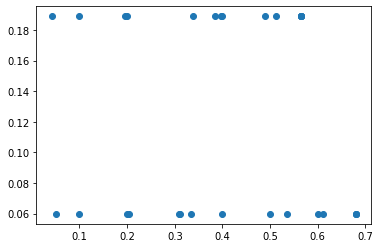

In [40]:
plt.scatter(df_groups_10['ftv_G10'], df_groups_10['network_gain'])
plt.scatter(df_groups_100['ftv_G100'], df_groups_100['network_gain'])
plt.scatter(df_regular['ftv'], df_regular['network_gain'])

In [30]:
# files_groups = os.listdir(simulator_path + 'sim_results/groups/')
# files_groups = [f for f in files_groups if not os.path.isdir(f)]
# files_groups_g100 = match_regex_array(files_groups, r".*_G100[_.].*")
# files_groups_g10 = match_regex_array(files_groups, r".*_G10[_.].*")
# files_groups_gK = match_regex_array(files_groups, r".*_G10[_]?.*")
# max_groups = match_regex_array(files_groups, r'.*Fmax.*')
# tv_groups = match_regex_array(files_groups, r'.*FTV.*')
# kl_groups = match_regex_array(files_groups, r'.*FKL.*')
# print(len(max_groups))
# print(len(tv_groups))
# print(len(kl_groups))
# df.head()


In [54]:
plt.scatter(np.arange(len(df_regular['pNA'][0])), df_regular['pNA'][0])
# plt.plot(df_groups_10['pNA'][0])

ValueError: x and y must be the same size

ValueError: Image size of 104064x248 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>